## Семинар 9: "LSTM"

ФИО: Дорожинский Владислав Игоревич

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

/home/user/Documents/MachineLearning/mlenv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_ii = nn.Parameter(torch.Tensor(hidden_size, input_size).zero_())
        self.W_if = nn.Parameter(torch.Tensor(hidden_size, input_size).zero_())
        self.W_ig = nn.Parameter(torch.Tensor(hidden_size, input_size).zero_())
        self.W_io = nn.Parameter(torch.Tensor(hidden_size, input_size).zero_())
        
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size).zero_())
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size).zero_())
        self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size).zero_())
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size).zero_())
        
        self.b_i = nn.Parameter(torch.Tensor(hidden_size).zero_())
        self.b_f = nn.Parameter(torch.Tensor(hidden_size).zero_())
        self.b_g = nn.Parameter(torch.Tensor(hidden_size).zero_())
        self.b_o = nn.Parameter(torch.Tensor(hidden_size).zero_())
        
    def forward(self, inputs, hidden):
        h_0, c_0 = hidden
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, 1, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            i_1 = torch.sigmoid(torch.matmul(self.W_ii, inp) + torch.matmul(self.W_hi, h_0) + self.b_i)
            f_1 = torch.sigmoid(torch.matmul(self.W_if, inp) + torch.matmul(self.W_hf, h_0) + self.b_f)
            g_1 = torch.tanh(torch.matmul(self.W_ig, inp) + torch.matmul(self.W_hg, h_0) + self.b_g)
            o_1 = torch.sigmoid(torch.matmul(self.W_io, inp) + torch.matmul(self.W_ho, h_0) + self.b_o)
            
            c_0 = f_1 * c_0 + i_1 * g_1
            h_0 = o_1 * torch.tanh(c_0)
            out[i, 0] = h_0
        return out, (h_0, c_0)
            
        

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM сделать решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

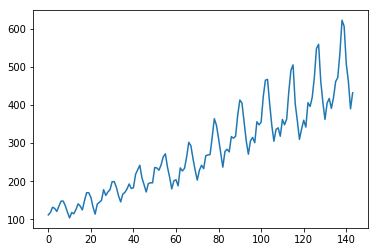

In [2]:
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [3]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [5]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [168]:
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [169]:
class PassengerDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY

    def __len__(self):
        return len(self.trainY)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx]
    
train_dataset = PassengerDataset(trainX, trainY)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

test_dataset = PassengerDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [182]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(1)
        batch_size = inp.size(0)
        hidden = (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cuda().detach(),
                  Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cuda().detach())
        inp = pack_sequence(inp)
        
#         o, _ = pad_packed_sequence(inp)
#         print(o.size())
#         plt.plot(o.cpu().data.numpy()[:,0,0])
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out)
#         print(lstm_out.size())
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [286]:
lstm = LSTMModel(8, 1).cuda()

In [292]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, verbose=True, patience=100)

In [294]:
n_epochs = 1000
loss_f = nn.MSELoss()
for epoch in range(n_epochs):
    losses = []
    for X, Y in train_dataloader:
        lstm.zero_grad()
        X = Variable(torch.FloatTensor(X)).view(-1, look_back, 1).cuda()
        Y = Variable(torch.FloatTensor(Y)).view(-1, 1).cuda()
        p = lstm(X)
        
#         plt.plot(X.cpu().data.numpy()[0,:,0])
#         plt.scatter([look_back], p.cpu().data.numpy()[0])
#         plt.scatter([look_back], Y.cpu().data.numpy()[0])
        
        loss = loss_f(p, Y)
        losses.append(loss.data.item())
        loss.backward()
        optimizer.step()
#         break
#     scheduler.step(np.mean(losses))
    if epoch % 100 == 0:
        print('[{}]: {}'.format(epoch, np.mean(losses)))
#     break

[0]: 6.708600994898006e-05
[100]: 5.521522143681068e-05
[200]: 9.870983376458753e-05
[300]: 7.175587597885169e-05
[400]: 5.6208942623925395e-05
[500]: 6.745362043147907e-05
[600]: 7.850187103031203e-05
[700]: 6.705013220198452e-05
[800]: 6.393254443537444e-05
[900]: 7.011498382780701e-05


In [284]:
def generate(model, n, inputs):
    result = np.zeros(n + len(inputs))
    result[:len(inputs)] = inputs
    for i in range(n):
        inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(1, len(inputs), 1).cuda()
        res = lstm(inp)
        result[i + len(inputs)] = res[-1].cpu().data.numpy()
    return result

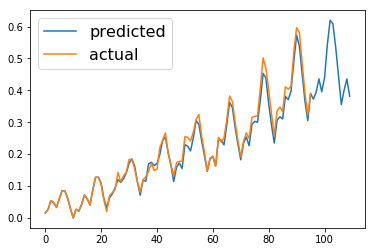

In [299]:
seq = train[:,0]
start = 0
plength = 90
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)

In [413]:
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [414]:
lstm = LSTM(1, 1)
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-2)

In [415]:
for epoch in range(150):
    losses = np.empty(shape=[trainX.shape[0]])
    for i in range(trainX.shape[0]):
        lstm.zero_grad()
        hidden = (Variable(torch.randn(1, 1, 1) * 0.1),
              Variable(torch.randn(1, 1, 1) * 0.1))
        inputs = Variable(torch.from_numpy(trainX[i, 0, :])).view(-1, 1, 1)
        out, hidden = lstm(inputs, hidden)
        y = Variable(torch.from_numpy(trainY[i:i+1]), requires_grad=False)
        y_ = out[-1].view(-1)
#         y_ = Variable(torch.from_numpy(trainX[i, :, -1]), requires_grad=False).view(-1)
        
        loss = torch.nn.functional.mse_loss(y_, y)
        losses[i] = loss.data[0]
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(epoch, np.mean(losses))

0 0.00410097320813
10 0.00238567652762
20 0.00208885786625
30 0.00198757237011
40 0.00190304212827
50 0.00193733459823
60 0.00199093639325
70 0.00189025864263
80 0.00179251316435
90 0.00192789669852
100 0.00189876166984
110 0.00200784298739
120 0.00182594507721
130 0.00185376005623
140 0.00186396930482


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: